<a href="https://colab.research.google.com/github/shivangvijay/CycleGAN/blob/main/CycleGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Reading dataset
import os
os.chdir('/content/drive/My Drive/')

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor, i, stringg, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    img = image_grid.permute(1, 2, 0).squeeze()
    save_image("/content/drive/My Drive/mlProject_dataset/output/" + str(i) + stringg + ".png", img)
    plt.imshow(img)
    plt.show()


import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))
        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A
        self.new_perm()
        assert len(self.files_A) > 0 

    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[self.randperm[index]]))
        if item_A.shape[0] != 3: 
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3: 
            item_B = item_B.repeat(3, 1, 1)
        if index == len(self) - 1:
            self.new_perm()
        return (item_A - 0.5) * 2, (item_B - 0.5) * 2

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        ''' Taking image as input, tansforms and returns the image tensor by Residual Block'''
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x

In [ ]:
class ContractingBlock(nn.Module):
    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class ExpandingBlock(nn.Module):
    def __init__(self, input_channels, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

    def forward(self, x):
        x = self.conv(x)
        return x

# **CycleGAN Generator**

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        '''A series of 2 contracting blocks, 9 residual blocks, and 2 expanding blocks to 
        transform an input image into an image from the other class, with an upfeature
        layer at the start and a downfeature layer at the end.
        Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output'''
        super(Generator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        '''Function for completing a forward pass of Generator: 
        Given an image tensor, passes it through the U-Net with residual blocks
        and returns the output.
        Parameter:
            x: image tensor of shape (batch size, channels, height, width)'''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)
        return self.tanh(xn)

# **PatchGAN Discriminator**

In [ ]:
class Discriminator(nn.Module):
    '''Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake. 
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)
        return xn

In [ ]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss()  # an adversarial loss function to keep track of how well the GAN is fooling the discriminator and how well the discriminator is catching the GAN
recon_criterion = nn.L1Loss()  # a loss function that rewards similar images to the ground truth, which "reconstruct" the image

n_epochs = 20  # the number of times we iterate through the entire dataset when training
dim_A = 3   # the number of channels of the images in pile A
dim_B = 3   # the number of channels of the images in pile B (In the visualization this is currently treated as equivalent to dim_A)
display_step = 200   # how often to display/visualize the images
batch_size = 1    # the number of images per forward/backward pass
lr = 0.0002    # the learning rate
load_shape = 286  # the size for the dataset to load the images at before randomly cropping them to target_shape as a simple data augmentation
target_shape = 256    # the size of the input and output images (in pixels)
device = 'cuda'   # the device type

In [ ]:
# load the images of the dataset while introducing some data augmentation (e.g. crops and random horizontal flips).
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

import torchvision
dataset = ImageDataset("mlProject_dataset", transform=transform)

# **Loading Model**

In [ ]:
gen_AB = Generator(dim_A, dim_B).to(device)   # Generator for class A to class B (gen_AB)
gen_BA = Generator(dim_B, dim_A).to(device)   # Generator for class B to class A (gen_BA)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)    # Discriminator for class A (disc_A)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)    # Discriminator for class A (disc_A)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# False if we want to train from scratch
pretrained = False
if pretrained:
    pre_dict = torch.load('cycleGAN_2200.pth')
    gen_AB.load_state_dict(pre_dict['gen_AB'])
    gen_BA.load_state_dict(pre_dict['gen_BA'])
    gen_opt.load_state_dict(pre_dict['gen_opt'])
    disc_A.load_state_dict(pre_dict['disc_A'])
    disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
    disc_B.load_state_dict(pre_dict['disc_B'])
    disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])
else:
    gen_AB = gen_AB.apply(weights_init)
    gen_BA = gen_BA.apply(weights_init)
    disc_A = disc_A.apply(weights_init)
    disc_B = disc_B.apply(weights_init)

# **Discriminator Loss**

In [ ]:
# implementing the discriminator loss
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    ''' 
    Returns the loss of the discriminator given inputs.
    Parameters:
        real_X: the real images from pile X
        fake_X: the generated images of class X
        disc_X: the discriminator for class X; takes images and returns real/fake class X
            prediction matrices
        adv_criterion: the adversarial loss function; takes the discriminator 
            predictions and the target labels and returns a adversarial 
            loss (which you aim to minimize)
    '''
    disc_fake_X_hat = disc_X(fake_X.detach()) 
    disc_fake_X_loss = adv_criterion(disc_fake_X_hat, torch.zeros_like(disc_fake_X_hat))
    disc_real_X_hat = disc_X(real_X)
    disc_real_X_loss = adv_criterion(disc_real_X_hat, torch.ones_like(disc_real_X_hat))
    disc_loss = (disc_fake_X_loss + disc_real_X_loss) / 2
    return disc_loss

# **Generator Loss**

Adversial Loss

In [ ]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    '''
    Returns the adversarial loss of the generator given inputs
    Parameters:
        real_X: the real images from pile X
        disc_Y: the discriminator for class Y; takes images and returns real/fake class Y
            prediction matrices
        gen_XY: the generator for class X to Y; takes images and returns the images 
            transformed to class Y
        adv_criterion: the adversarial loss function; takes the discriminator 
                  predictions and the target labels and returns a adversarial 
                  loss (which you aim to minimize)
    '''
    fake_Y = gen_XY(real_X)
    disc_fake_Y_hat = disc_Y(fake_Y)
    adversarial_loss = adv_criterion(disc_fake_Y_hat, torch.ones_like(disc_fake_Y_hat))
    return adversarial_loss, fake_Y

Identity Loss

In [ ]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
    '''
    Returns the identity loss of the generator given inputs
    Parameters:
        real_X: the real images from pile X
        gen_YX: the generator for class Y to X; takes images and returns the images 
            transformed to class X
        identity_criterion: the identity loss function; takes the real images from X and
                        those images put through a Y->X generator and returns the identity 
                        loss (which you aim to minimize)
    '''
    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(identity_X, real_X)
    return identity_loss, identity_X

Cycle consistency Loss

In [ ]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    '''
    Returns the cycle consistency loss of the generator given inputs
    Parameters:
        real_X: the real images from pile X
        fake_Y: the generated images of class Y
        gen_YX: the generator for class Y to X; takes images and returns the images 
            transformed to class X
        cycle_criterion: the cycle consistency loss function; takes the real images from X and
                        those images put through a X->Y generator and then Y->X generator
                        and returns the cycle consistency loss (which you aim to minimize)
    '''
    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(cycle_X, real_X)
    return cycle_loss, cycle_X

Total Gnerator Loss

In [ ]:
def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=100, lambda_cycle=10): # Lambda_identity:0.1
    '''
    Returns the loss of the generator given inputs.
    Parameters:
        real_A: the real images from pile A
        real_B: the real images from pile B
        gen_AB: the generator for class A to B; takes images and returns the images 
            transformed to class B
        gen_BA: the generator for class B to A; takes images and returns the images 
            transformed to class A
        disc_A: the discriminator for class A; takes images and returns real/fake class A
            prediction matrices
        disc_B: the discriminator for class B; takes images and returns real/fake class B
            prediction matrices
        adv_criterion: the adversarial loss function; takes the discriminator 
            predictions and the true labels and returns a adversarial 
            loss (which you aim to minimize)
        identity_criterion: the reconstruction loss function used for identity loss
            and cycle consistency loss; takes two sets of images and returns
            their pixel differences (which you aim to minimize)
        cycle_criterion: the cycle consistency loss function; takes the real images from X and
            those images put through a X->Y generator and then Y->X generator
            and returns the cycle consistency loss (which you aim to minimize).
            Note that in practice, cycle_criterion == identity_criterion == L1 loss
        lambda_identity: the weight of the identity loss
        lambda_cycle: the weight of the cycle-consistency loss
    '''
    # Adversarial Loss
    adv_loss_BA, fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    adv_loss_AB, fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    gen_adversarial_loss = adv_loss_BA + adv_loss_AB
  
    # Identity Loss
    identity_loss_A, identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
    identity_loss_B, identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)
    gen_identity_loss = identity_loss_A + identity_loss_B

    # Cycle-consistency Loss
    cycle_loss_BA, cycle_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_loss_AB, cycle_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    gen_cycle_loss = cycle_loss_BA + cycle_loss_AB
 
    # Total loss
    gen_loss = lambda_identity * gen_identity_loss + lambda_cycle * gen_cycle_loss + gen_adversarial_loss

    return gen_loss, fake_A, fake_B

# **Cycle GAN Training**

In [ ]:
import imageio
class CONFIG:
    #IMAGE_WIDTH = 210
    #IMAGE_HEIGHT = 240
    #COLOR_CHANNELS = 3
    #NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 

# Function to save the image
def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255)
    image=np.array(image)
    image = image.astype('uint8')
    imageio.imwrite(path,image)

Epoch 0: Step 0: Generator (U-Net) loss: 0.11205883979797364, Discriminator loss: 0.0014030593633651734


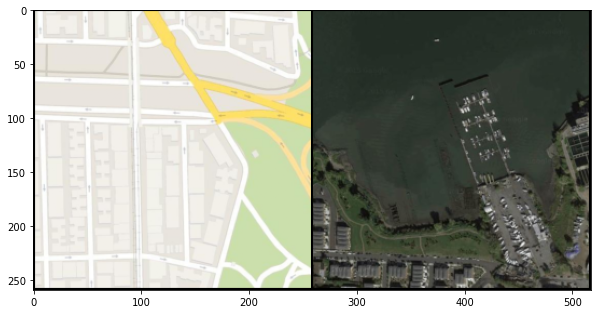

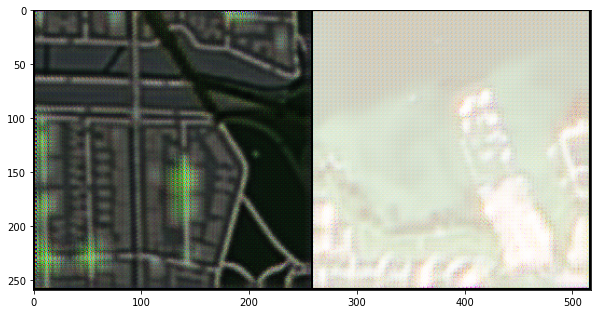

Epoch 0: Step 200: Generator (U-Net) loss: 30.064811620712288, Discriminator loss: 0.2673782538622618


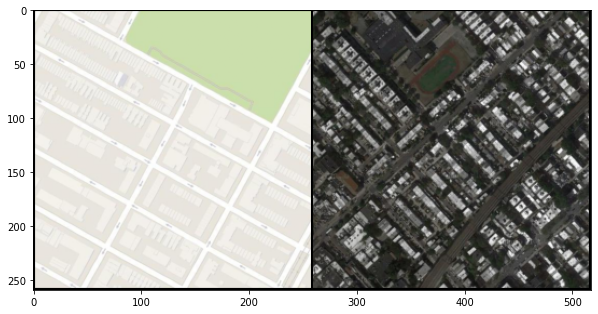

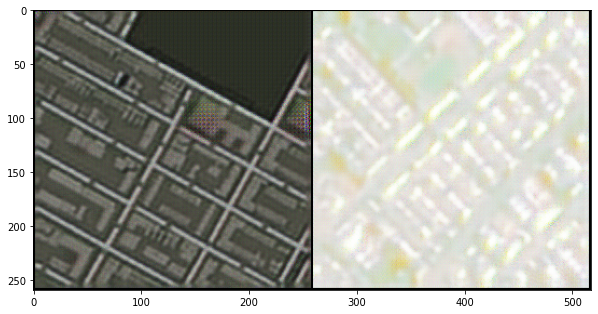

Epoch 0: Step 400: Generator (U-Net) loss: 26.30386575698851, Discriminator loss: 0.2536365881562233


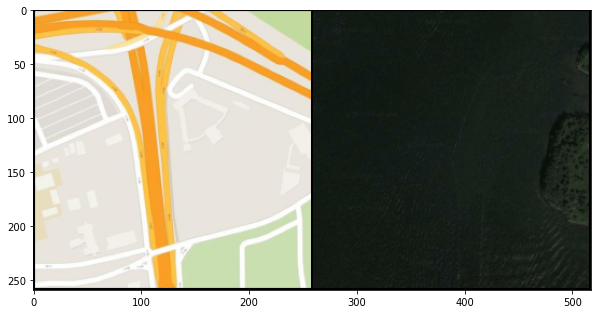

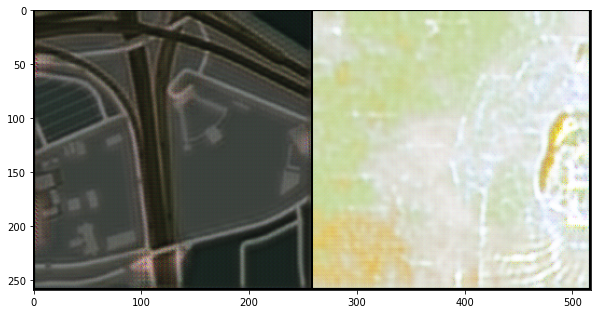

Epoch 0: Step 600: Generator (U-Net) loss: 23.26484738826752, Discriminator loss: 0.2528127270191908


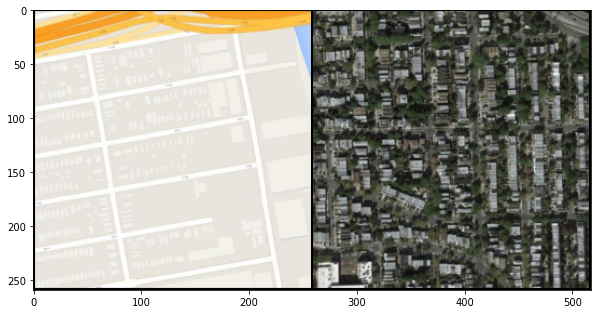

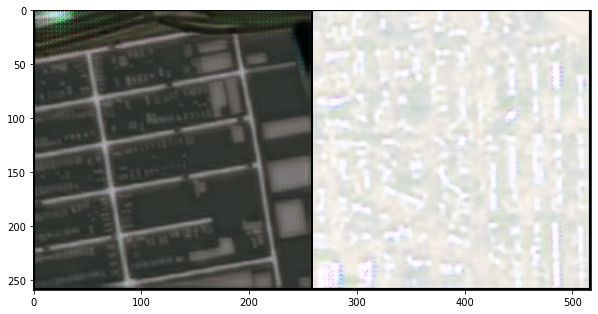

Epoch 0: Step 800: Generator (U-Net) loss: 21.08673679351807, Discriminator loss: 0.23243847183883184


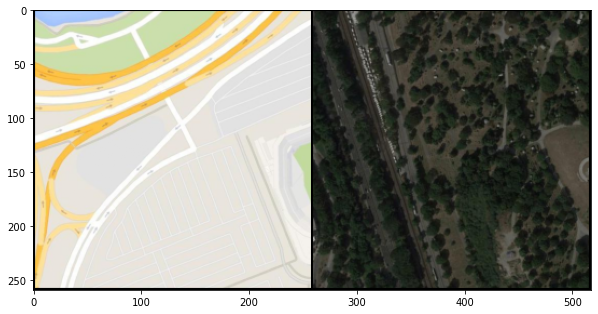

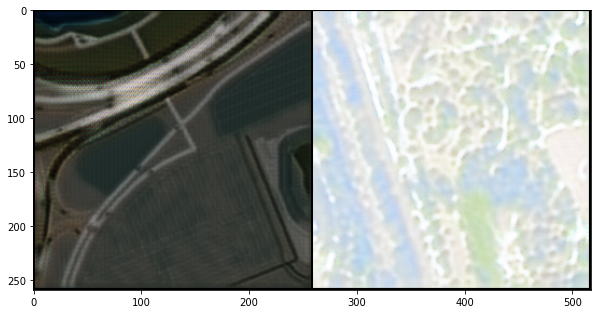

Epoch 0: Step 1000: Generator (U-Net) loss: 21.995181488990774, Discriminator loss: 0.22287379149347558


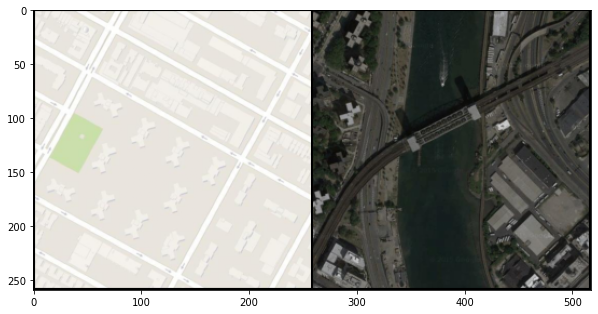

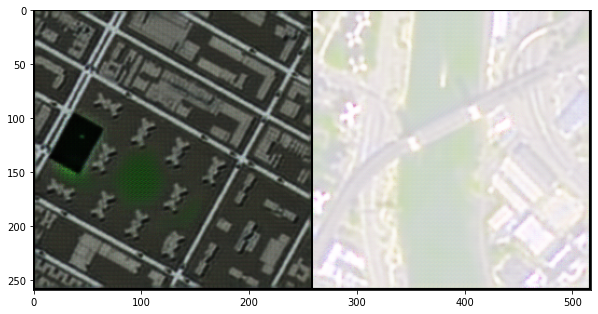

Epoch 1: Step 1200: Generator (U-Net) loss: 19.712840685844412, Discriminator loss: 0.21384550947695968


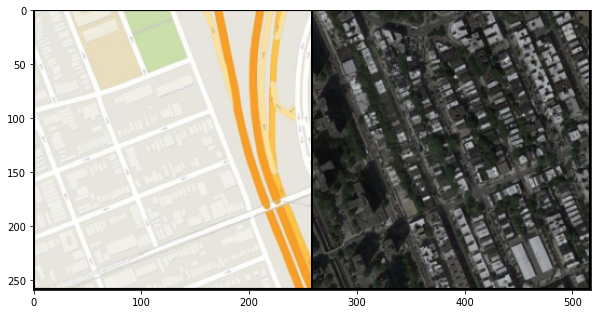

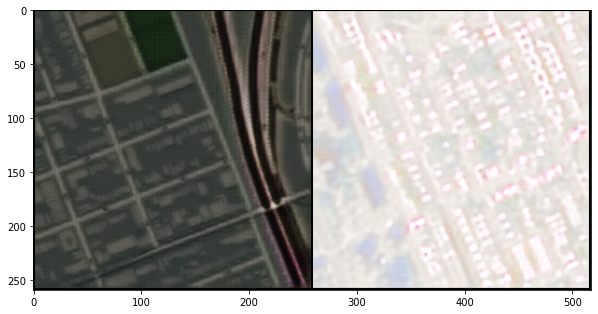

Epoch 1: Step 1400: Generator (U-Net) loss: 18.92114437580108, Discriminator loss: 0.21752863176167017


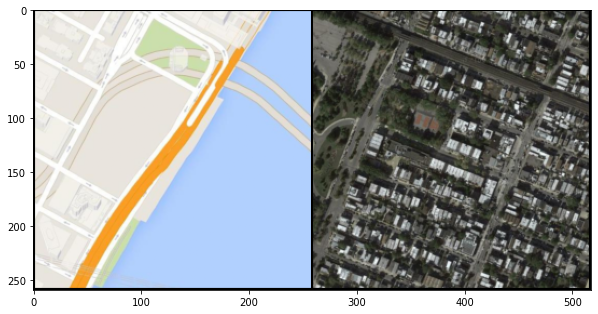

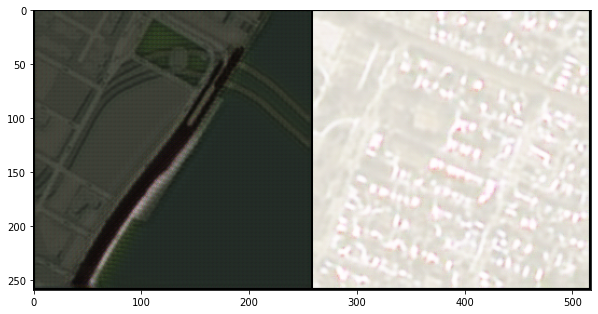

Epoch 1: Step 1600: Generator (U-Net) loss: 20.3011348104477, Discriminator loss: 0.20815666202455754


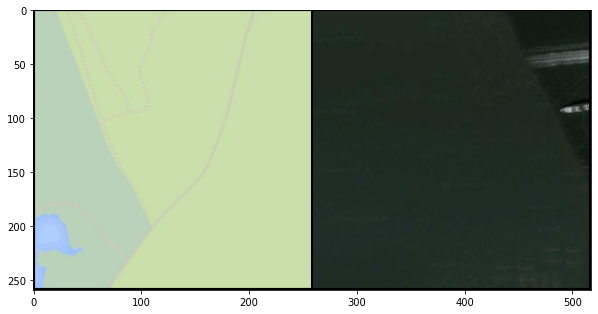

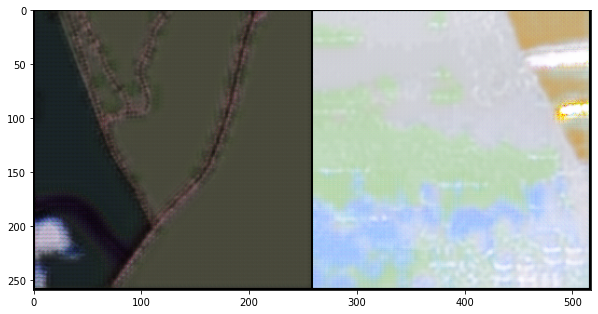

In [ ]:
from skimage import color
import numpy as np
plt.rcParams["figure.figsize"] = (10, 10)


def train(save_model=True):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0

    for epoch in range(n_epochs):
        # Dataloader returns the batches for image, _ in tqdm(dataloader):
        for real_A, real_B in tqdm(dataloader):
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)
 
            # Update discriminator A
            disc_A_opt.zero_grad()    # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True)
            disc_A_opt.step() 

            # Update discriminator B
            disc_B_opt.zero_grad()       # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_B = gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True) 
            disc_B_opt.step()

            # Update generator
            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward()  # Update gradients
            gen_opt.step()  # Update optimizer
 
            # Keeping track of the average discriminator loss
            mean_discriminator_loss += disc_A_loss.item() / display_step
            # Keeping track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            # Visualization
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_A, real_B]), epoch, 'real', size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), epoch, 'fake', size=(dim_B, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                if save_model:
                    torch.save({
                        'gen_AB': gen_AB.state_dict(),
                        'gen_BA': gen_BA.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_A': disc_A.state_dict(),
                        'disc_A_opt': disc_A_opt.state_dict(),
                        'disc_B': disc_B.state_dict(),
                        'disc_B_opt': disc_B_opt.state_dict()
                    }, f"cycleGAN_{cur_step}.pth")
            cur_step += 1
train()